In [ ]:
!pip install -q qiskit  qiskit[visualization] qiskit-aer qiskit-ibm-runtime
# Setup: Import everything we need
import math
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

print(f"✅ Qiskit version: {qiskit.__version__}")
print("🚀 Ready to go!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.0 MB/s eta 0:00:00
ERROR: pip's d

shorturl.at/nWYEN

# Grover's Algorithm Tutorial

## Background

Grover's algorithm is one of the most famous quantum algorithms! It provides a **quadratic speedup** for searching unsorted databases. While a classical computer needs to check roughly N/2 items on average to find what it's looking for, Grover's algorithm only needs about √N steps.

**Key concepts:**
- **Oracle**: Marks the states we want to find (flips their phase)
- **Amplification**: Increases the probability of measuring marked states
- **Quadratic speedup**: √N instead of N/2 steps

Let's build this step by step!

## Step 1: Understanding the Problem

Imagine you have a summer school pass list with 8 people, and you want to find "Alice".
- **Classical approach**: Check each entry one by one (worst case: 8 searches)
- **Grover's approach**: Use quantum superposition + amplification (only ~2 iterations!)

In binary, let's say we're looking for states "001" out of 8 possible 3-bit states.

## Classical Randomised Search

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_transition_matrix(N, marked_element):
    """Create NxN transition matrix for sampling with marked absorbing state"""
    P = np.zeros((N, N))

    for col in range(N):
        element = col + 1  # Elements are 1-indexed
        if element == marked_element:
            # Marked element: absorbing state - once there, stay there
            P[marked_element-1, col] = 1.0
        else:
            # Other elements: uniform transition to all states (including marked)
            P[:, col] = 1/N

    return P

def simulate_probability_evolution(N, marked_element, steps=10):
    """Simulate how probabilities evolve over time"""

    # Initial uniform distribution
    prob_vector = np.ones(N) / N

    # Transition matrix
    P = create_transition_matrix(N, marked_element)

    print(f"Transition Matrix (N={N}, marked={marked_element}):")
    print(P)
    print()

    # Track evolution
    evolution = [prob_vector.copy()]

    print("Probability Evolution:")
    print(f"Step 0: {prob_vector}")

    for step in range(1, steps+1):
        prob_vector = P @ prob_vector
        evolution.append(prob_vector.copy())
        print(f"Step {step}: {prob_vector}")

    return evolution, P

def plot_evolution(evolution, marked_element, N):
    """Plot histograms showing probability distribution at each step"""

    # Create subplots for different steps
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    steps_to_show = [0, 1, 2, 3, 5, len(evolution)-1]
    elements = list(range(1, N+1))

    for i, step in enumerate(steps_to_show):
        if step < len(evolution):
            probs = evolution[step]

            # Color marked element differently
            colors = ['red' if elem == marked_element else 'blue' for elem in elements]

            axes[i].bar(elements, probs, color=colors, alpha=0.7)
            axes[i].set_title(f'Step {step}')
            axes[i].set_xlabel('Element')
            axes[i].set_ylabel('Probability')
            axes[i].set_ylim(0, 1)
            axes[i].grid(True, alpha=0.3)

            # Highlight marked element probability
            marked_prob = probs[marked_element-1]
            axes[i].text(marked_element, marked_prob + 0.05, f'{marked_prob:.3f}',
                        ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_theoretical_comparison(evolution, marked_element, N):
    """Compare simulation results with theoretical formula 1-(7/8)^t"""

    # Extract probabilities of marked element at specific steps
    simulation_steps = [1, 2, 3, 5, 8]
    simulation_probs = []

    for step in simulation_steps:
        if step < len(evolution):
            marked_prob = evolution[step-1][marked_element-1]
            simulation_probs.append(marked_prob)

    # Calculate theoretical probabilities using 1-(7/8)^t
    # For N=8, probability of not being absorbed at each step is 7/8
    # So probability of being in marked state at step t is 1-(7/8)^t
    theoretical_steps = list(range(1, 9))  # t = 1,2,3,4,5,6,7,8
    prob_not_absorbed = (N-1)/N  # This is 7/8 for N=8

    # Probability of being in marked state at step t: 1-(7/8)^t
    theoretical_probs = [1 - (prob_not_absorbed)**t for t in theoretical_steps]

    # Create comparison plot
    plt.figure(figsize=(8, 6))

    # Main plot: Compare simulation with 1-(7/8)^t
    plt.bar(simulation_steps, simulation_probs, alpha=0.7, color='red',
            label='Simulation P(marked)', width=0.4)
    plt.plot(theoretical_steps, theoretical_probs, 'b--', label='Theoretical: 1-(7/8)^t',
             linewidth=3, alpha=0.8)

    # Add points for the specific steps we're comparing
    theory_at_sim_steps = [1 - (prob_not_absorbed)**t for t in simulation_steps]
    plt.plot(simulation_steps, theory_at_sim_steps, 'bs', markersize=8,
             label='Theory at simulation steps')

    plt.xlabel('Step (t)', fontsize=12)
    plt.ylabel('Probability of being in marked state', fontsize=12)
    plt.title('Simulation vs Theory: P(marked state) = 1-(7/8)^t', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Add text annotations showing the close match
    for i, (step, sim_prob, theo_prob) in enumerate(zip(simulation_steps, simulation_probs, theory_at_sim_steps)):
        diff = abs(sim_prob - theo_prob)
        plt.annotate(f'Δ={diff:.6f}',
                    xy=(step, sim_prob), xytext=(step+0.2, sim_prob+0.02),
                    fontsize=9, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print numerical comparison
    print("\nNumerical Comparison:")
    print("Step\tSimulation P(marked)\tTheory 1-(7/8)^t\tDifference")
    print("-" * 65)
    for step, sim_prob in zip(simulation_steps, simulation_probs):
        theo_prob = 1 - (prob_not_absorbed)**step
        diff = abs(sim_prob - theo_prob)
        print(f"{step}\t{sim_prob:.8f}\t\t{theo_prob:.8f}\t\t{diff:.2e}")

    print(f"\nNote: For N={N}, the theoretical formula is 1-({N-1}/{N})^t = 1-(7/8)^t")






Transition Matrix (N=8, marked=2):
[[0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 1.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.    0.125 0.125 0.125 0.125 0.125 0.125]]

Probability Evolution:
Step 0: [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Step 1: [0.109375 0.234375 0.109375 0.109375 0.109375 0.109375 0.109375 0.109375]
Step 2: [0.09570312 0.33007812 0.09570312 0.09570312 0.09570312 0.09570312
 0.09570312 0.09570312]
Step 3: [0.08374023 0.41381836 0.08374023 0.08374023 0.08374023 0.08374023
 0.08374023 0.08374023]
Step 4: [0.07327271 0.48709106 0.07327271 0.07327271 0.07327271 0.07327271
 0.07327271 0.07327271]
Step 5: [0.06411362 0.55120468 0.06411362 0.06411362 0.06411362 0.06411362
 0.06411362 0.064113

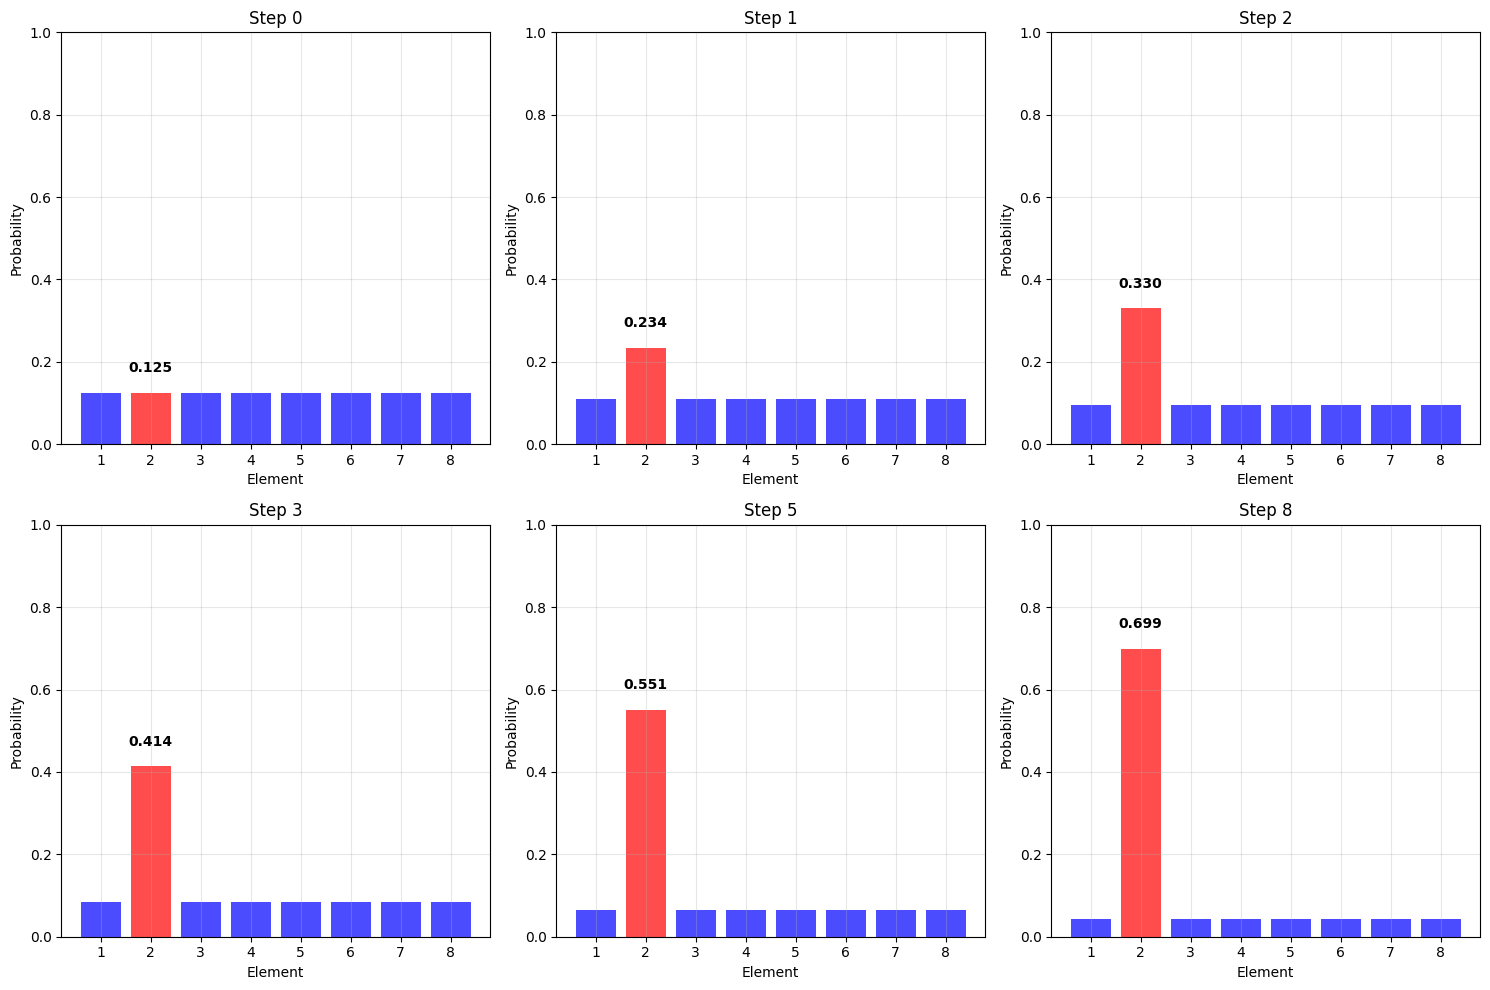

In [ ]:
# Run simulation
N = 8
marked_element = 2
steps = 8

evolution, P = simulate_probability_evolution(N, marked_element, steps)
plot_evolution(evolution, marked_element, N)

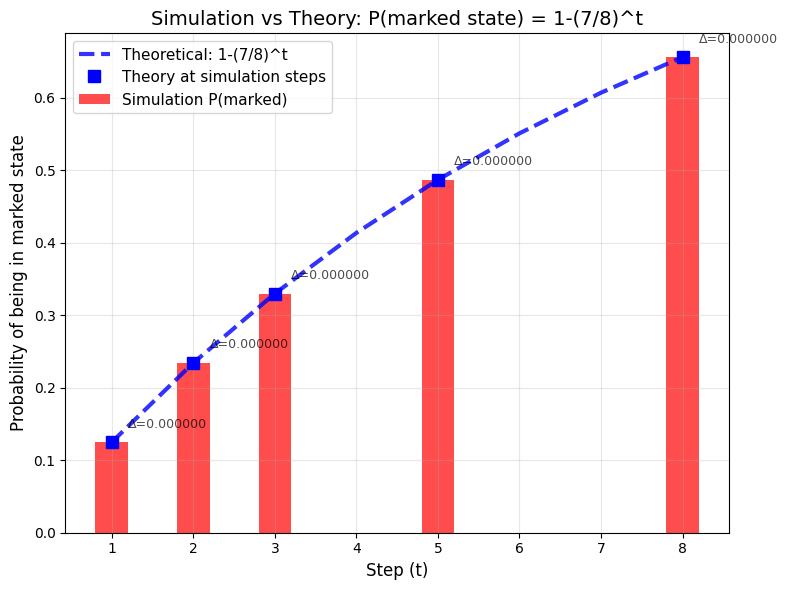


Numerical Comparison:
Step	Simulation P(marked)	Theory 1-(7/8)^t	Difference
-----------------------------------------------------------------
1	0.12500000		0.12500000		0.00e+00
2	0.23437500		0.23437500		0.00e+00
3	0.33007812		0.33007812		0.00e+00
5	0.48709106		0.48709106		0.00e+00
8	0.65639108		0.65639108		0.00e+00

Note: For N=8, the theoretical formula is 1-(7/8)^t = 1-(7/8)^t


In [ ]:
plot_theoretical_comparison(evolution, marked_element, N)

# Quantum Grover Search

In [ ]:
# Define our search problem
marked_states = ["001"]  # The states we want to find
num_qubits = 3  # 3 qubits = 8 possible states (000 to 111)

print("🎯 Search Problem:")
print(f"Total possible states: {2**num_qubits}")
print(f"States we want to find: {marked_states}")

# Let's see what all 8 states look like
all_states = []
for i in range(2**num_qubits):
    binary = format(i, f'0{num_qubits}b')
    marker = "← TARGET!" if binary in marked_states else ""
    all_states.append(f"{binary} {marker}")

print("\nAll possible 3-bit states:")
for state in all_states:
    print(f"  {state}")

🎯 Search Problem:
Total possible states: 8
States we want to find: ['001']

All possible 3-bit states:
  000 
  001 ← TARGET!
  010 
  011 
  100 
  101 
  110 
  111 


## Step 2: Building the Oracle

The **oracle** is a quantum circuit that "marks" our target states by flipping their phase from +1 to -1. This doesn't change measurement probabilities yet, but it prepares them for amplification.

**How it works:**
- For each target state, apply X gates where the bit is '0'
- Apply a multi-controlled Z gate
- Apply X gates again to "undo" the flips


 Oracle circuit for ['001']:


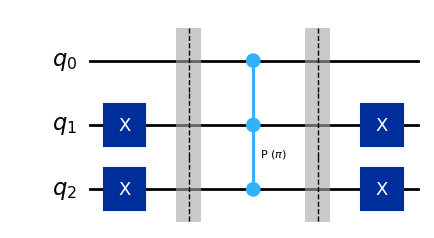

In [ ]:
def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)

    for target in marked_states:
        rev_target = target[::-1]
        zero_positions = [i for i in range(num_qubits) if rev_target[i] == '0']

        # Apply X gates to flip 0s to 1s
        qc.x(zero_positions)
        qc.barrier()
        # Apply multi-controlled Z gate
        if num_qubits == 1:
            qc.z(0)
        elif num_qubits == 2:
            qc.cz(0, 1)
        else:
            # For 3+ qubits, use all qubits as controls for Z gate on last qubit
            control_qubits = list(range(num_qubits-1))
            target_qubit = num_qubits - 1
            qc.mcp(np.pi, control_qubits, target_qubit)  # Multi-controlled phase gate
        qc.barrier()
        # Apply X gates again to flip back
        qc.x(zero_positions)

    return qc

# Create our oracle
oracle = grover_oracle(marked_states)
print(f"\n Oracle circuit for {marked_states}:")
display(oracle.draw('mpl'))

## Step 3: Testing the Oracle

Let's verify our oracle works by checking what it does to different states:

In [ ]:
# Test the oracle on different states
from qiskit.quantum_info import Statevector

print("Testing the Oracle")
print("=" * 40)

# Test each possible 3-qubit state
for i in range(2**num_qubits):
    binary = format(i, f'0{num_qubits}b')

    # Create initial state
    qc_test = QuantumCircuit(num_qubits)

    # Prepare the specific computational basis state
    for j, bit in enumerate(binary[::-1]):  # Reverse for Qiskit ordering
        if bit == '1':
            qc_test.x(j)

    # Apply oracle
    qc_test.compose(oracle, inplace=True)

    # Get the final state
    state = Statevector.from_instruction(qc_test)

    # Check if phase was flipped (negative amplitude)
    phase_flipped = any(amp.real < 0 for amp in state.data if abs(amp) > 1e-10)
    marker = "MARKED ✓" if phase_flipped else "unmarked"

    print(f"State |{binary}⟩: {marker}")

print("\n💡 The oracle successfully marks our target states!")

Testing the Oracle
State |000⟩: unmarked
State |001⟩: MARKED ✓
State |010⟩: unmarked
State |011⟩: unmarked
State |100⟩: unmarked
State |101⟩: unmarked
State |110⟩: unmarked
State |111⟩: unmarked

💡 The oracle successfully marks our target states!


## Step 4: The Grover Operator

The **Grover operator** combines the oracle with a "diffusion operator" that amplifies marked states. Qiskit provides this as `GroverOperator` - let's use it and see what it looks like:

🔄 Grover Operator Structure:
Number of qubits: 3

Decomposed Grover operator:


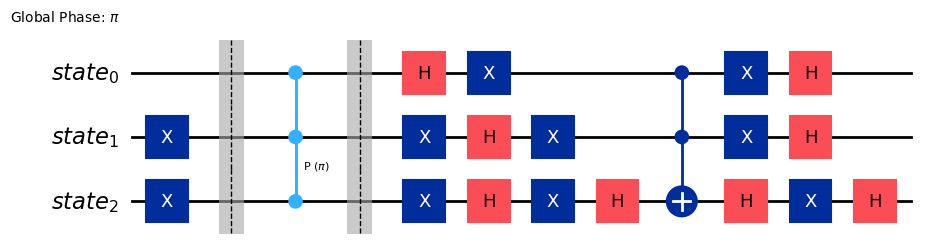


📖 How it works:
1. Oracle: Marks target states (phase flip)
2. Hadamard gates: Change to computational basis
3. X gates + Multi-controlled Z: Rotate around average
4. X gates + Hadamard gates: Change back to superposition basis
Result: Amplifies marked states, suppresses others!


In [ ]:
# Create the Grover operator
grover_op = GroverOperator(oracle)

print("🔄 Grover Operator Structure:")
print(f"Number of qubits: {grover_op.num_qubits}")

# Let's see the decomposed circuit
print("\nDecomposed Grover operator:")
display(grover_op.decompose().draw('mpl'))

print("\n📖 How it works:")
print("1. Oracle: Marks target states (phase flip)")
print("2. Hadamard gates: Change to computational basis")
print("3. X gates + Multi-controlled Z: Rotate around average")
print("4. X gates + Hadamard gates: Change back to superposition basis")
print("Result: Amplifies marked states, suppresses others!")

## Step 5: Calculating Optimal Iterations

Grover's algorithm has an optimal number of iterations. Too few and you don't amplify enough; too many and you start reducing the probability again!

**Formula:** `π/4 * arcsin(√(M/N))` where M = marked states, N = total states

In [ ]:
# Calculate optimal number of iterations
def calculate_optimal_iterations(num_marked, num_total_states):
    """Calculate optimal Grover iterations"""
    ratio = num_marked / num_total_states
    optimal = math.pi / (4 * math.asin(math.sqrt(ratio)))
    return math.floor(optimal)

num_marked = len(marked_states)
num_total = 2**num_qubits

optimal_iterations = calculate_optimal_iterations(num_marked, num_total)

print("📊 Grover's Algorithm Analysis:")
print(f"Total states: {num_total}")
print(f"Marked states: {num_marked}")
print(f"Success probability (random): {num_marked/num_total:.3f}")
print(f"Optimal iterations: {optimal_iterations}")

# Let's see what happens with different iteration counts
print(f"\nIteration analysis:")
for iterations in range(0, 8):
    # Approximate success probability after 'iterations' steps
    theta = math.asin(math.sqrt(num_marked / num_total))
    prob = math.sin((2*iterations + 1) * theta)**2
    print(f"  {iterations} iterations: ~{prob:.3f} success probability")

print(f"\n🎯 Optimal choice: {optimal_iterations} iterations!")

📊 Grover's Algorithm Analysis:
Total states: 8
Marked states: 1
Success probability (random): 0.125
Optimal iterations: 2

Iteration analysis:
  0 iterations: ~0.125 success probability
  1 iterations: ~0.781 success probability
  2 iterations: ~0.945 success probability
  3 iterations: ~0.330 success probability
  4 iterations: ~0.012 success probability
  5 iterations: ~0.548 success probability
  6 iterations: ~1.000 success probability
  7 iterations: ~0.577 success probability

🎯 Optimal choice: 2 iterations!


## Step 6: Building the Complete Grover Circuit

Now let's put it all together:
1. **Initialize**: Equal superposition of all states (Hadamard gates)
2. **Amplify**: Apply Grover operator optimal number of times
3. **Measure**: See the results!

🏗️ Building Grover circuit with 2 iterations
  Step 1: Initialize with Hadamard gates
  Step 2: Apply Grover operator 2 times
  Step 3: Add measurements

📋 Complete Grover Circuit:
Circuit depth: 4
Circuit width: 6

Circuit diagram:


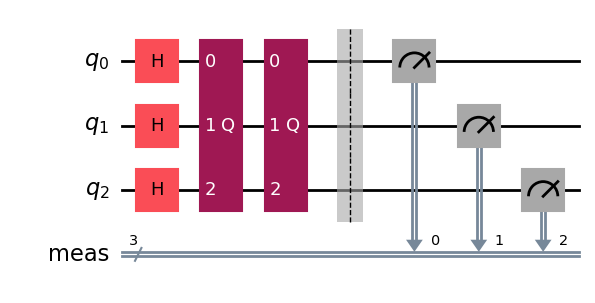

In [ ]:
# Build the complete Grover circuit
def build_grover_circuit(oracle, optimal_iterations):
    """Build complete Grover search circuit"""

    num_qubits = oracle.num_qubits
    qc = QuantumCircuit(num_qubits)

    print(f"🏗️ Building Grover circuit with {optimal_iterations} iterations")

    # Step 1: Create equal superposition
    print("  Step 1: Initialize with Hadamard gates")
    qc.h(range(num_qubits))

    # Step 2: Apply Grover operator optimal number of times
    print(f"  Step 2: Apply Grover operator {optimal_iterations} times")
    grover_op = GroverOperator(oracle)
    qc.compose(grover_op.power(optimal_iterations), inplace=True)

    # Step 3: Measure all qubits
    print("  Step 3: Add measurements")
    qc.measure_all()

    return qc

# Create the complete circuit
grover_circuit = build_grover_circuit(oracle, optimal_iterations)

print(f"\n📋 Complete Grover Circuit:")
print(f"Circuit depth: {grover_circuit.depth()}")
print(f"Circuit width: {grover_circuit.width()}")
print("\nCircuit diagram:")
display(grover_circuit.draw('mpl'))

## Step 7: Running the Algorithm

Time to see Grover's algorithm in action! We'll run it on a simulator and see if it finds our target states:

In [ ]:
# Run Grover's algorithm
def run_grover_experiment(circuit, shots=10000):
   simulator = AerSimulator()
   compiled_circuit = transpile(circuit, simulator)
   job = simulator.run(compiled_circuit, shots=shots)
   result = job.result()
   counts = result.get_counts()

   # Parse measurement results properly
   parsed_counts = {}
   for measurement_string, count in counts.items():
       if ' ' in measurement_string:
           actual_measurement = measurement_string.split()[0]
       else:
           actual_measurement = measurement_string

       if actual_measurement in parsed_counts:
           parsed_counts[actual_measurement] += count
       else:
           parsed_counts[actual_measurement] = count

   return parsed_counts

# Run the experiment
results = run_grover_experiment(grover_circuit)

print("📊 RESULTS:")
print("=" * 40)

total_shots = sum(results.values())
target_count = 0

print("All measurement outcomes:")
for state, count in sorted(results.items()):
   percentage = count / total_shots * 100
   is_target = state in marked_states
   marker = "🎯 TARGET!" if is_target else ""

   if is_target:
       target_count += count

   print(f"  |{state}⟩: {count:4d} ({percentage:5.1f}%) {marker}")

target_percentage = target_count / total_shots * 100
classical_random = len(marked_states) / 2**num_qubits * 100



📊 RESULTS:
All measurement outcomes:
  |000⟩:   75 (  0.8%) 
  |001⟩: 9472 ( 94.7%) 🎯 TARGET!
  |010⟩:   75 (  0.8%) 
  |011⟩:   66 (  0.7%) 
  |100⟩:   96 (  1.0%) 
  |101⟩:   84 (  0.8%) 
  |110⟩:   69 (  0.7%) 
  |111⟩:   63 (  0.6%) 


## Step 8: Visualizing the Results

Let's create a nice visualization of our results:

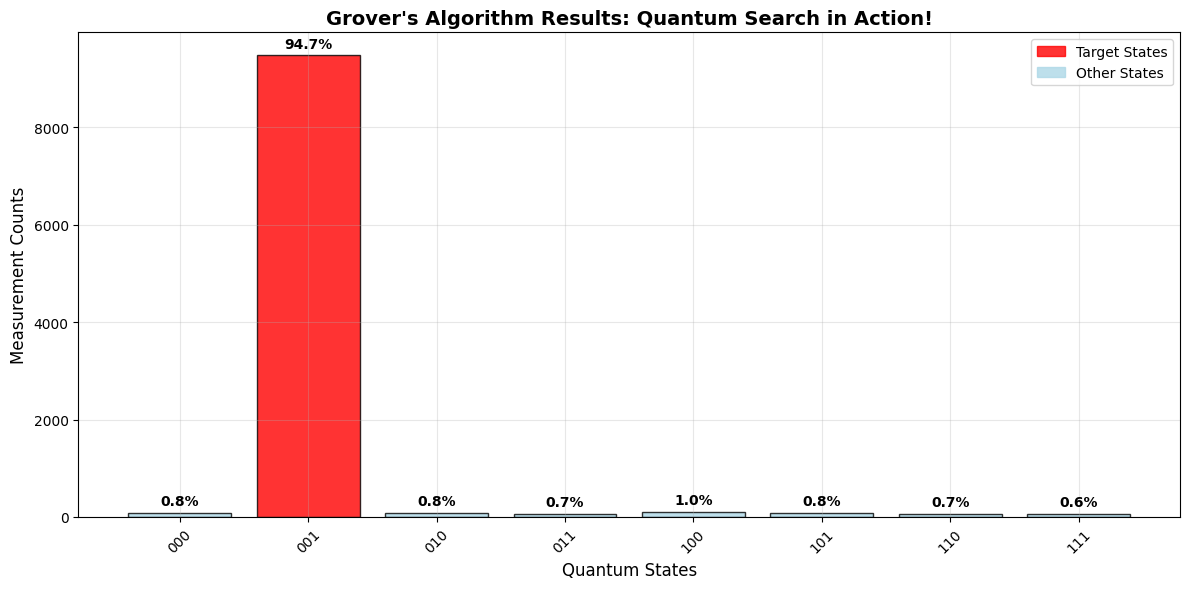

In [ ]:
# Create visualization
def visualize_grover_results(results, marked_states):
    """Create a nice visualization of Grover's results"""

    # Prepare data
    states = sorted(list(results.keys()))
    counts = list(results[i] for i in states)
    total = sum(counts)

    # Color coding: targets in red, others in blue
    colors = ['red' if state in marked_states else 'lightblue' for state in states]

    # Create the plot
    plt.figure(figsize=(12, 6))

    bars = plt.bar(states, counts, color=colors, alpha=0.8, edgecolor='black')

    # Add percentage labels on bars
    for bar, count in zip(bars, counts):
        percentage = count / total * 100
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + total*0.01,
                f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Formatting
    plt.xlabel('Quantum States', fontsize=12)
    plt.ylabel('Measurement Counts', fontsize=12)
    plt.title("Grover's Algorithm Results: Quantum Search in Action!", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)

    # Add legend
    import matplotlib.patches as mpatches
    target_patch = mpatches.Patch(color='red', alpha=0.8, label='Target States')
    other_patch = mpatches.Patch(color='lightblue', alpha=0.8, label='Other States')
    plt.legend(handles=[target_patch, other_patch])

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary
    target_count = sum(results.get(state, 0) for state in marked_states)
    target_percentage = target_count / total * 100
    classical_percentage = len(marked_states) / 2**len(states[0]) * 100



# Visualize our results
visualize_grover_results(results, marked_states)

# Quantum Transiplation
Courtesy: Prof. Subhajit Roy

ADD measurements
Original Circuit diagram:


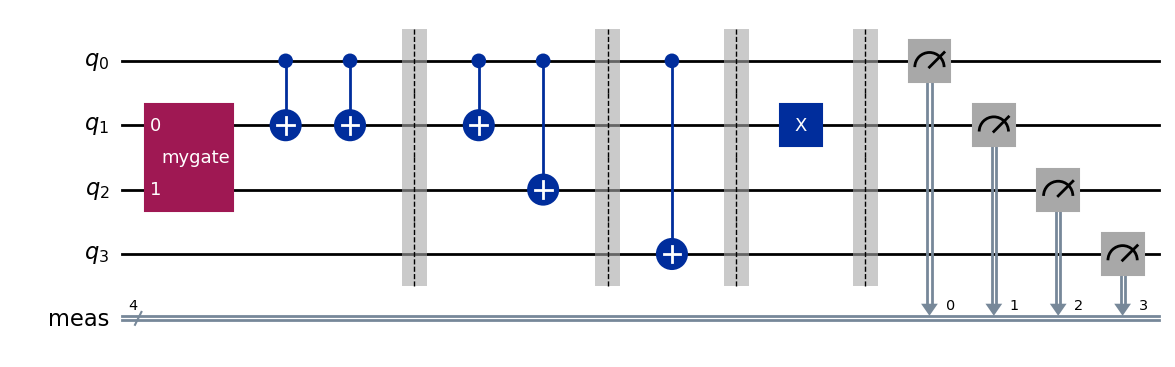

 Decomposed Circuit diagram: 


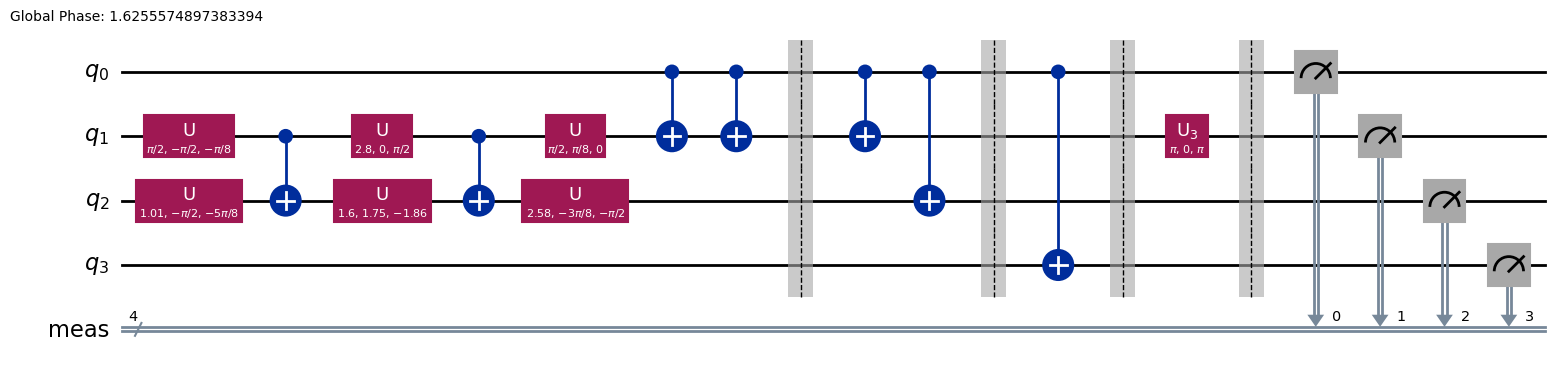


Quantum circuit characteristics
 Depth: 8
 Number of qubits: 4
 Operations: {'cx': 5, 'barrier': 4, 'measure': 4, 'unitary': 1, 'x': 1}
 Number of multi-qubit Operations: 6


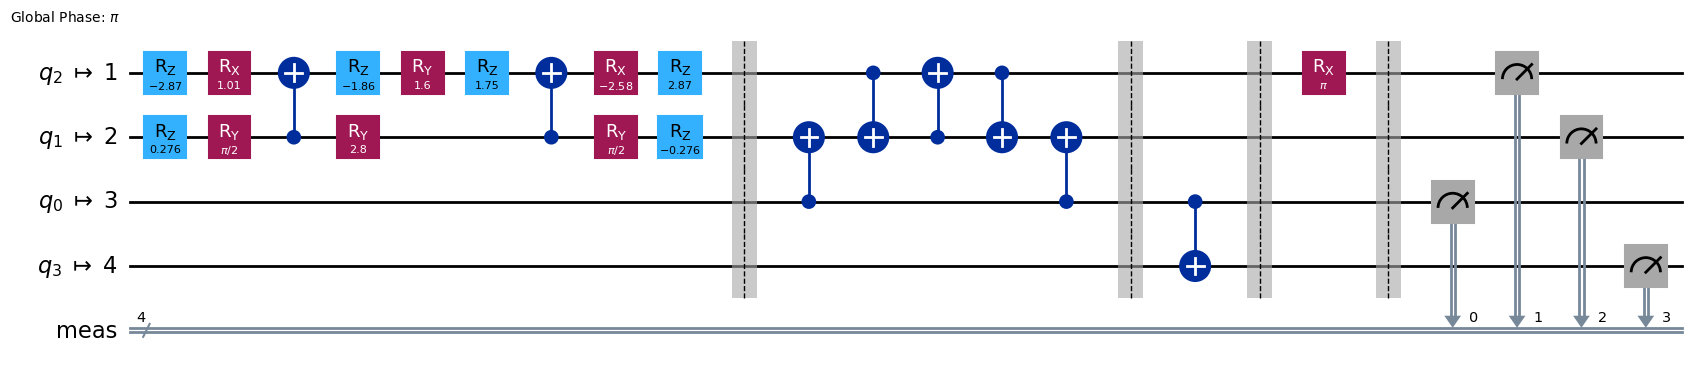

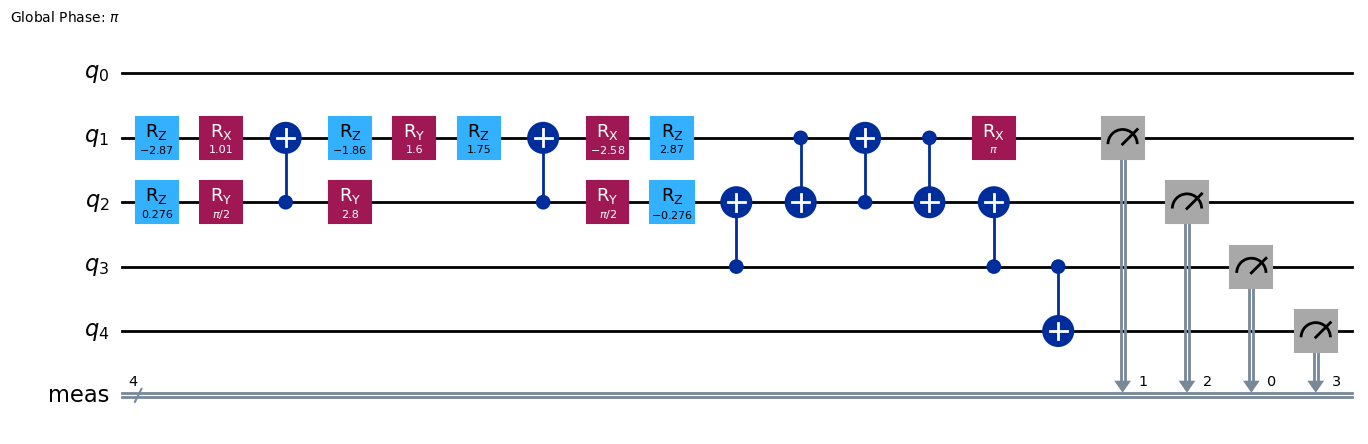

In [ ]:
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import numpy as np
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, circuit_drawer
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import RemoveBarriers

def createNoiseModel(): # Define a simple noise model with depolarizing errors
  # Example error probabilities
  p_reset = 0.03
  p_meas = 0.1
  p_gate1 = 0.05

  # QuantumError objects
  error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
  error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
  error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
  error_gate2 = error_gate1.tensor(error_gate1)

  # Add errors to noise model
  noise_bit_flip = NoiseModel()
  noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
  noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
  noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
  noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

def createCouplingMap():
  num_qubits = 5
  cm = CouplingMap.from_line(num_qubits) # linear coupling
  #cm = CouplingMap.from_heavy_hex(3)
  return cm

def print_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = dict(qc.count_ops())
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    print("Quantum circuit characteristics")
    print(" Depth:", depth)
    print(" Number of qubits:", num_qubits)
    print(" Operations:", ops)
    print(" Number of multi-qubit Operations:", num_multi_qubit_ops)

def getCircuit():
  # RBS gate with input pi/4
  angle = np.pi/4
  angle = np.random.random()
  matrix = [[1, 0, 0, 0],
            [0, np.cos(angle), np.sin(angle), 0],
            [0, -np.sin(angle), np.cos(angle), 0],
            [0, 0, 0, 1]]
  mygate = UnitaryGate(matrix, label="mygate")

  circuit = QuantumCircuit(4)
  circuit.append(mygate, [1,2])
  circuit.cx(0,1)
  circuit.cx(0,1)
  circuit.barrier()
  circuit.cx(0,1)
  circuit.cx(0,2)
  circuit.barrier()
  circuit.cx(0,3)
  circuit.barrier()
  circuit.x(1)

  print("ADD measurements")
  circuit.measure_all()
  return circuit

circuit = getCircuit()
print("Original Circuit diagram:")
display(circuit.draw('mpl'))
qc_dec = circuit.decompose()
print(" Decomposed Circuit diagram: ")
display(qc_dec.draw('mpl'))

print()
print_qc_characteristics(circuit)


num_qubits = 5
cm = CouplingMap.from_line(num_qubits) # Nearest-neighbors connectivity / Line connectivity
backend = GenericBackendV2(num_qubits, basis_gates = ["rx","ry","rz","h", "cx"], coupling_map=cm)

# transpile the quantum circuit for the basis gate of our example backend
qc_synth1 = generate_preset_pass_manager(2, backend=backend, seed_transpiler=307).run(qc_dec)
display(qc_synth1.draw('mpl'))
print()
qc_synth1 = RemoveBarriers()(qc_synth1)
display(qc_synth1.draw('mpl'))
print()
